<a href="https://colab.research.google.com/github/wladrod/Aprendizaje-Automatico-2022/blob/master/notebooks/24-Aprendizaje_por_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
    <h1>Tema 4: Redes Neuronales</h1>
    <h1>Aprendizaje por Transferencia</h1>
    <br>
    <h5>Prof. Wladimir Rodríguez</h5>
    <h5>wladimir@ula.ve</h5>
    <h5>Departamento de Computación</h5>
</center>

El aprendizaje por transferencia (*transfer learning*) es una técnica poderosa para entrenar redes neuronales profundas que le permite a uno tomar el conocimiento aprendido sobre un problema de aprendizaje profundo y aplicarlo a un problema de aprendizaje diferente pero similar.

El uso del aprendizaje por transferencia puede acelerar drásticamente la tasa de implementación de una aplicación que está diseñando, haciendo que tanto el entrenamiento como la implementación de su red neuronal profunda sean más simples y fáciles.

En esta clase repasaremos la teoría detrás del aprendizaje por transferencia y veremos cómo llevar a cabo un ejemplo de aprendizaje por transferencia en redes neuronales convolucionales (CNN) en PyTorch.

### ¿Qué es el aprendizaje por transferencia?

La idea detrás del aprendizaje por transferencia es tomar un modelo entrenado en una tarea y aplicarlo a una segunda tarea similar. El hecho de que un modelo ya haya entrenado algunos o todos los pesos para la segunda tarea significa que el modelo se puede implementar mucho más rápido. Esto permite una evaluación rápida del rendimiento y el ajuste del modelo, lo que permite una implementación más rápida en general. El aprendizaje por transferencia se está volviendo cada vez más popular en el campo del aprendizaje profundo, gracias a la gran cantidad de recursos computacionales y el tiempo necesario para entrenar modelos de aprendizaje profundo, además de conjuntos de datos grandes y complejos.

La principal limitación del aprendizaje por transferencia es que las características del modelo aprendidas durante la primera tarea son generales y no específicas de la primera. En la práctica, esto significa que los modelos entrenados para reconocer ciertos tipos de imágenes pueden reutilizarse para reconocer otras imágenes, siempre que las características generales de las imágenes sean similares.

### Modelos pre-entrenados para la clasificación de imágenes

Los modelos preentrenados son modelos de redes neuronales entrenados con conjuntos de datos de referencia muy grandes como `ImageNet`. El objetivo de `ImageNet` es clasificar con precisión las imágenes de entrada (más de 14 millones) en un conjunto de 1000 categorías de objetos comunes que los sistemas de visión artificial "verán" en la vida cotidiana. 

<img src='../figuras/ImageNet.png' />

La comunidad de aprendizaje profundo se ha beneficiado enormemente de estos modelos de código abierto. Además, los modelos preentrenados son un factor importante para los rápidos avances en la investigación de *Computer Vision*. Otros investigadores y profesionales pueden usar estos modelos de última generación en lugar de reinventar todo desde cero.

<img src='../figuras/Model_Timeline.png'/>

Estos son algunos de los modelos preentrenados mas utilizados:

- AlexNet
- VGG16
- Inception
- ResNet

### Arquitectura de AlexNet


<img src='../figuras/AlexNet.png'/>

### Arquitectura de VGG16


<img src='../figuras/vgg16.png'/>

### Arquitectura de InceptionV3


<img src='../figuras/inceptionV3.png'/>

### Arquitectura de ResNet


<img src='../figuras/ResNet.png'/>

## Ejemplo de Clasificación usando ResNet50 para clasificar Alien vs Predator

En este ejemplo usaremos una data de [kaggle](https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images) para clasificar las imagenes de `alien` y `predator`. Usando aprendizaje por transferencia con una red `ResNet50`.

### Importar las librerías

In [34]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
torch.__version__

'1.12.1'

### Preparación de los datos

In [38]:
data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,),)])

In [39]:
# Bajar la data de entrenamiento 
datos_entrenamiento = datasets.FashionMNIST(
    root='../datos/',
    download=True, 
    train=True, 
    transform=data_transform)

# Bajar la data de validación
datos_validacion = datasets.FashionMNIST(
    root='../datos/',
    download=True, 
    train=False, 
    transform=data_transform)

In [40]:
tamaño_lote = 32

# Crear cargadores para los datos de entrenamiento y validación
cargador_entrenamiento = DataLoader(datos_entrenamiento,
                                    batch_size=tamaño_lote,
                                    shuffle=True)
cargador_validacion = DataLoader(datos_validacion, 
                                 batch_size=tamaño_lote,
                                 shuffle=False)

print(f"Dataloaders: {cargador_entrenamiento, cargador_validacion}") 
print(f"Length of train dataloader: {len(cargador_entrenamiento)} batches of {tamaño_lote}")
print(f"Length of test dataloader: {len(cargador_validacion)} batches of {tamaño_lote}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x16cecb130>, <torch.utils.data.dataloader.DataLoader object at 0x16ce86a90>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


### Definir dispositivo a utilizar

In [41]:
if torch.backends.mps.is_available():
    dispositivo = 'mps'
elif torch.cuda.is_available():
    dispositivo = "cuda"
else: "cpu"
dispositivo

'mps'

### Crear modelo basado en `ResNet50`

In [42]:
class MnistResNet(nn.Module):
  def __init__(self, in_channels=1):
    super(MnistResNet, self).__init__()

    # Load a pretrained resnet model from torchvision.models in Pytorch
    self.model = models.resnet50(weights='DEFAULT')

    # Change the input layer to take Grayscale image, instead of RGB images. 
    # Hence in_channels is set as 1 or 3 respectively
    # original definition of the first layer on the ResNet class
    # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Change the output layer to output 10 classes instead of 1000 classes
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 10)

  def forward(self, x):
    return self.model(x)

In [59]:
torch.manual_seed(42)
modelo = MnistResNet().to(dispositivo)

### Definir función de perdida y optimizador

In [60]:
perdida_fn = nn.CrossEntropyLoss()
optimizador = optim.Adam(modelo.parameters(), lr=3e-4)

### Función para entrenar el modelo

In [61]:
def paso_entrenamiento(modelo, 
             dataloader,
             perdida_fn, 
             optimizador):
    # Colocar modelo en modo entrenamiento
    modelo.train()
    
    # Inicializar valores de perdida y exactitud del entrenamiento
    perdida_entrenamiento, exactitud_entrenamiento = 0, 0
    
    # Iterar sobre los lotes del DataLoader
    for imagenes, etiquetas in dataloader:
        # Enviar datos al dispositivo
        imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
        
        # 1. Propagar hacia adelante los datos de entrenamiento usando el método forward()
        salida = modelo(imagenes)
        
        # 2. Calcule la pérdida (qué tan diferentes son las predicciones de nuestros modelos con respecto a la verdad del terreno)
        perdida = perdida_fn(salida, etiquetas)
        perdida_entrenamiento += perdida.item() 
        
        # 3. Colocar a cero los gradientes del optimizador
        optimizador.zero_grad()
        
        # 4. Propagación hacia atrás
        perdida.backward()
        
        # 5. Realizar paso de optimización
        optimizador.step()
        
        # Calcular y acumular la exactitud sobre todos los lotes
        clase_predicha = torch.argmax(torch.softmax(salida, dim=1), dim=1)
        exactitud_entrenamiento += (clase_predicha == etiquetas).sum().item()/len(salida)
    
    # Ajustar métricas para obtener un promedio de la perdida y la exactitud por lote
    perdida_entrenamiento /= len(dataloader)
    exactitud_entrenamiento /= len(dataloader)

    return perdida_entrenamiento, exactitud_entrenamiento

In [62]:
def paso_validacion(modelo,
            dataloader,
            perdida_fn):
        
    # Colocar el modelo en modo evaluación
    modelo.eval()

    # Inicializar valores de perdida y exactitud de la validación
    perdida_validacion, exactitud_validacion = 0, 0
    
    # Iniciar el manejador de contexto para inferencia
    with torch.inference_mode():
        # Iterar sobre los lotes del DataLoader
        for imagenes, etiquetas in dataloader:
            # Enviar datos al dispositivo
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            
            # 1. Propagar hacia adelante los datos de entrenamiento usando el método forward()
            salida = modelo(imagenes)
            
            # 2. Calcular y acumular la pérdida
            perdida = perdida_fn(salida, etiquetas)
            perdida_validacion += perdida.item()
            
            # 3. Calcular y acumular la exactitud
            clases_predicha = salida.argmax(dim=1)
            exactitud_validacion += ((clases_predicha == etiquetas).sum().item()/len(salida))
            
    # Ajustar métricas para obtener un promedio de la perdida y la exactitud por lote
    perdida_validacion /= len(dataloader)
    exactitud_validacion /= len(dataloader)
    
    return perdida_validacion, exactitud_validacion

In [63]:
from tqdm.auto import tqdm

def entrenar(modelo: torch.nn.Module,
             cargador_entrenamiento: torch.utils.data.DataLoader, 
             cargador_evaluacion: torch.utils.data.DataLoader, 
             optimizador: torch.optim.Optimizer,
             perdida_fn: torch.nn.Module = nn.CrossEntropyLoss(),
             epocas: int = 5):
    
    # 2. Crear diccionario vacio para los resultados
    resultados = {"perdida_entrenamiento": [],
        "exactitud_entrenamiento": [],
        "perdida_evaluacion": [],
        "exactitud_evaluacion": []
    }
    
    # 3. Iterar sobre los pasos de entrenamiento y prueba por un número de epocas
    for epoca in tqdm(range(epocas)):
        perdida_entrenamiento, exactitud_entrenamiento = paso_entrenamiento(modelo=modelo,
                                                                            dataloader=cargador_entrenamiento,
                                                                            perdida_fn=perdida_fn,
                                                                            optimizador=optimizador)
        perdida_evaluacion, exactitud_evaluacion = paso_validacion(modelo=modelo,
                                                                   dataloader=cargador_validacion,
                                                                   perdida_fn=perdida_fn)
        
        # 4. Imprimir que esta pasando
        print(
            f"Epoca: {epoca+1} | "
            f"perdida_entrenamiento: {perdida_entrenamiento:.4f} | "
            f"exactitud_entrenamiento: {exactitud_entrenamiento:.4f} | "
            f"perdida_evaluación: {perdida_evaluacion:.4f} | "
            f"exactitud_evaluación: {exactitud_evaluacion:.4f}"
        )

        # 5. Actualizar el diccionario de resultados
        resultados["perdida_entrenamiento"].append(perdida_entrenamiento)
        resultados["exactitud_entrenamiento"].append(exactitud_entrenamiento)
        resultados["perdida_evaluacion"].append(perdida_evaluacion)
        resultados["exactitud_evaluacion"].append(exactitud_evaluacion)

    # 6. Retornar el diccionario de resultadoss al final de cada epoca
    return resultados

In [64]:
# Fijar el número de epocas
NUMERO_EPOCAS = 5

# Inicializar el temporizador
from timeit import default_timer as timer 
tiempo_inicial = timer()

# Entrenar modelo  
modelo_resultados = entrenar(modelo=modelo,
                             cargador_entrenamiento=cargador_entrenamiento,
                             cargador_evaluacion=cargador_validacion,
                             optimizador=optimizador,
                             perdida_fn=perdida_fn,
                             epocas=NUMERO_EPOCAS)

# Finalizar el temporizador e imprimir cuanto tardo el entrenamiento
tiempo_final = timer()
print(f"Tiempo total de entrenamiento: {tiempo_final-tiempo_inicial:.3f} segundos")

  0%|          | 0/5 [00:00<?, ?it/s]

Perdida Entrenamiento: 0.29390 | Exactitud Entrenamiento: 0.89
Perdida Validación: 0.23895 | Exactitud Validación: 0.91
Epoca: 1 | perdida_entrenamiento: 0.2939 | exactitud_entrenamiento: 0.8941 | perdida_evaluación: 0.2390 | exactitud_evaluación: 0.9127
Perdida Entrenamiento: 0.18489 | Exactitud Entrenamiento: 0.93
Perdida Validación: 0.23097 | Exactitud Validación: 0.91
Epoca: 2 | perdida_entrenamiento: 0.1849 | exactitud_entrenamiento: 0.9323 | perdida_evaluación: 0.2310 | exactitud_evaluación: 0.9149
Perdida Entrenamiento: 0.15048 | Exactitud Entrenamiento: 0.95
Perdida Validación: 0.19394 | Exactitud Validación: 0.93
Epoca: 3 | perdida_entrenamiento: 0.1505 | exactitud_entrenamiento: 0.9465 | perdida_evaluación: 0.1939 | exactitud_evaluación: 0.9317
Perdida Entrenamiento: 0.12081 | Exactitud Entrenamiento: 0.96
Perdida Validación: 0.17135 | Exactitud Validación: 0.94
Epoca: 4 | perdida_entrenamiento: 0.1208 | exactitud_entrenamiento: 0.9556 | perdida_evaluación: 0.1713 | exactitud

In [65]:
def graficar_curvas_perdida(resultados):
    """Graficar las curvas de entrenamiento del diccionario de resultados.

    Argumentoss:
        resultadoss (dict): diccionario conteniendo una lista de valores containing list of valores.
            {"perdida_entrenamiento": [...],
             "exactitud_entrenamiento": [...],
             "perdida_evaluacion": [...],
             "exactitud_evaluacion": [...]}
    """
    
    # Obtener los valores de la perdida del diccionario de resultados (entrenamiento y validación)
    perdida = resultados['perdida_entrenamiento']
    perdida_validacion = resultados['perdida_evaluacion']

    # Obtener los valores de la exactitud del diccionario de resultados (entrenamiento y validación)
    exactitud = resultados['exactitud_entrenamiento']
    exactitud_validacion = resultados['exactitud_evaluacion']

    # Determinar el número de epocas
    epocas = range(len(resultados['perdida_entrenamiento']))

    # Configurar la gráfica 
    plt.figure(figsize=(15, 7))

    # Graficar la perdida
    plt.subplot(1, 2, 1)
    plt.plot(epocas, perdida, label='perdida_entrenamiento')
    plt.plot(epocas, perdida_validacion, label='perdida_validación')
    plt.title('Perdida')
    plt.xlabel('Epocas')
    plt.legend()

    # Graficar la exactitud
    plt.subplot(1, 2, 2)
    plt.plot(epocas, exactitud, label='exactitud_entrenamiento')
    plt.plot(epocas, exactitud_validacion, label='exactitud_validacion')
    plt.title('Exactitud')
    plt.xlabel('Epocas')
    plt.legend();

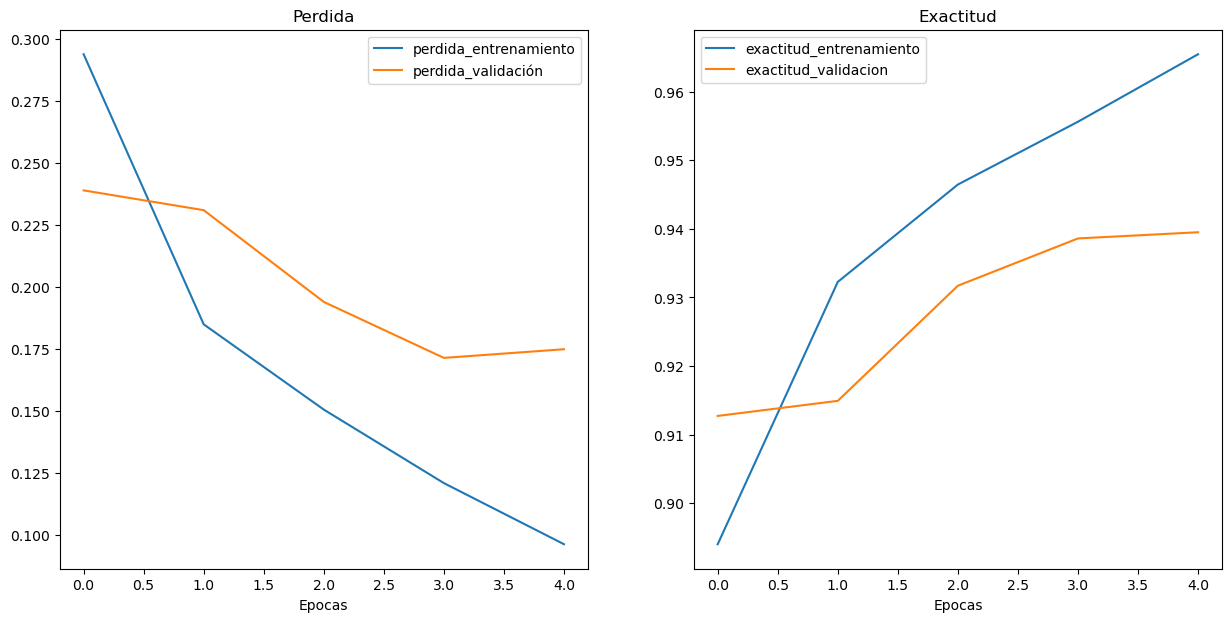

In [66]:
graficar_curvas_perdida(modelo_resultados)

### Validar modelo con algunas imágenes

In [9]:
caminos_imagen_validacion = ["validacion/alien/11.jpg",
                        "validacion/alien/22.jpg",
                        "validacion/predator/33.jpg"]
lista_imagenes = [Image.open(camino_datos + camino_imagen) for camino_imagen in caminos_imagen_validacion]

In [10]:
lote_validacion = torch.stack([transformadores_datos['validacion'](imagen).to(dispositivo)
                                for imagen in lista_imagenes])

In [11]:
# La salida del modelo no son probabilidades
predicciones_logits_tensor = modelo(lote_validacion)
predicciones_logits_tensor

/Users/wladimir/mambaforge/lib/python3.9/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1664817727684/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))


tensor([[ 1.7624, -2.2353],
        [ 0.4448, -0.9964],
        [-2.5696,  1.0717]], device='mps:0', grad_fn=<MpsLinearBackward0>)

In [12]:
# convertir el modelo a probabilidades
predicciones_probabilidades = F.softmax(predicciones_logits_tensor, dim=1).cpu().data.numpy()
predicciones_probabilidades

array([[0.98197454, 0.01802548],
       [0.8086474 , 0.1913526 ],
       [0.02554767, 0.9744524 ]], dtype=float32)

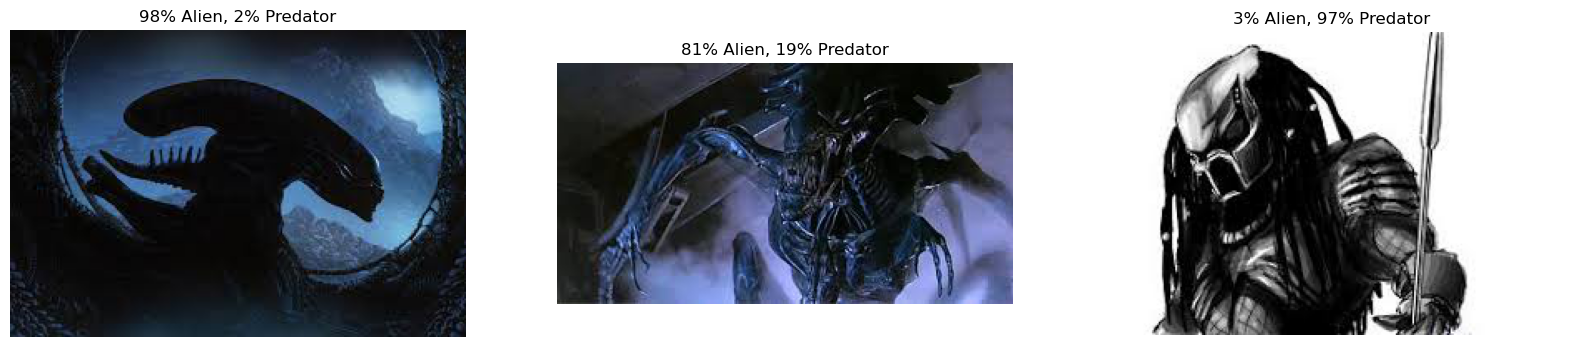

In [13]:
fig, axs = plt.subplots(1, len(lista_imagenes), figsize=(20, 5))
for i, imagen in enumerate(lista_imagenes):
    ax = axs[i]
    ax.axis('off')
    ax.set_title(f'{predicciones_probabilidades[i, 0] * 100:.0f}% Alien, {predicciones_probabilidades[i, 1] * 100:.0f}% Predator')
    ax.imshow(imagen)